A notebook for clustering celebrity chef recipes. Clustering by categories proved more effective than clustering either by titles or by titles and categories. All three approaches, evaluated by their inertia curves, are shown below. Inertia, or the within-cluster sum of squares criterion, measures how internally coherent clusters are.

#0. Setup

In [22]:
from nltk.stem import WordNetLemmatizer
# import numpy as np
import pymongo
import pickle
from tqdm import tqdm
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import Ward
import itertools
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

# import pymongo
# import pandas as pd
# from tqdm import tqdm
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from sklearn.feature_extraction.text import CountVectorizer
# #from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans
# import re
# import itertools
# from matplotlib import pyplot as plt
# import seaborn
# %matplotlib inline

In [5]:
client = pymongo.MongoClient()
chefs = client.chefs_db
celebrity_recipes = client.chefs_db.celebrity_recipes
recipe_links = client.chefs_db.celebrity_recipe_links

#1. Clustering by categories

DataFrame of categories:

In [6]:
categories_df = pd.DataFrame(columns=["Chef", "Recipe", "Categories"])
count = 0
for recipe in tqdm(recipe_links.find({}, {"chef": 1, "title": 1, "categories": 1, "_id": 0})):
    row = pd.DataFrame({"Chef": [recipe["chef"]], "Recipe": [recipe["title"]], 
                        "Categories": [recipe["categories"]]})
    row.index = [count]
    categories_df = categories_df.append(row)
    count += 1

In [7]:
categories_df.head(3)

,Categories,Chef,Recipe
0,"[Sugar, Dessert, Frosting]",Giada De Laurentiis,Vanilla Frosting
1,"[Salmon, Main Dish, Jewish Cooking]",Giada De Laurentiis,Salmon Baked in Foil
2,"[Chicken, Main Dish, Pasta Dishes]",Giada De Laurentiis,Italian Baked Chicken and Pastina


In [9]:
categories_df.iloc[0]

Categories    [Sugar, Dessert, Frosting]
Chef                 Giada De Laurentiis
Recipe                  Vanilla Frosting
Name: 0, dtype: object

In [8]:
len(categories_df)

8136

NLP on categories:

In [17]:
stops = {'Lunch','Easy','Sauce','Dinner','Dishes','Baking',
         'For A Crowd','Breakfast','Bread','Cheese','Parmesan'}
categories = [c for _, c in categories_df['Categories'].iteritems()]
categories = [[w for w in c if w not in stops] for c in categories]
categories = [' '.join(c) for c in categories] 
categories[:3]

[u'Sugar Dessert Frosting',
 u'Salmon Main Dish Jewish Cooking',
 u'Chicken Main Dish Pasta Dishes']

Vectorized categories:

In [18]:
c_cv = CountVectorizer(categories)
c_matrix = c_cv.fit_transform(categories).toarray()

Plotting inertia to determine optimal # of clusters (k):

minimum inertia: 13475.9851571  when k = 20


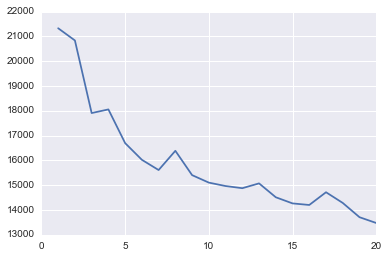

In [19]:
inertias = []
for k in tqdm(range(1,21)):
    km = KMeans(n_clusters=k, init = 'k-means++', max_iter = 100, n_init = 1)
    km.fit(c_matrix)
    i = km.inertia_
    inertias.append((k, i))
    
sort_by_i = sorted(inertias, key=lambda inertia: inertia[1])
sort_by_k = sorted(inertias)
print 'minimum inertia:', sort_by_i[0][1], ' when k =', sort_by_i[0][0]
plt.plot(range(1,21), [inertia[1] for inertia in sort_by_k])

Ultimately, after playing around a bunch (and as inertia rates and cluster boundaries tended to vary), I found a particular combination of 14 k-means clusters that gave me adequate baseline groupings for what I wanted: three distinct courses. Load the particular model from the picklefile below, or try your own hand at the interpretation game!

In [ ]:
#k-means clustering
kmeans14 = KMeans(n_clusters=14)
kmeansclusters14 = kmeans14.fit_predict(c_matrix)

In [ ]:
#ward hierarchical agglomerative clustering
ward14 = Ward(n_clusters=14)
wardclusters14 = ward14.fit_predict(c_matrix)

In [23]:
with open('kmeans_baseline_14_clusters.pkl', 'r') as picklefile:
    baseline_clusters = pickle.load(picklefile)

In [24]:
categories_df['Cluster1'] = baseline_clusters

In [25]:
categories_df.head(3)

,Categories,Chef,Recipe,Cluster1
0,"[Sugar, Dessert, Frosting]",Giada De Laurentiis,Vanilla Frosting,12
1,"[Salmon, Main Dish, Jewish Cooking]",Giada De Laurentiis,Salmon Baked in Foil,10
2,"[Chicken, Main Dish, Pasta Dishes]",Giada De Laurentiis,Italian Baked Chicken and Pastina,6


Interpreting our clusters, grouping `categories_df` by `Cluster1` and examining each group:

```
by_course = categories_df.groupby('Cluster1')
by_course.get_group(0) 
by_course.get_group(1)
#etc.
```
0. salad
1. potato (side)
2. side dish
3. dessert
4. main dish
5. appetizer
6. pasta (main)
7. beverage
8. lunch, sandwiches
9. grab bag
10. main dish
11. main dish grilling
12. dessert
13. breakfast

Refining clusters:

In [26]:
cluster2 = []
for _, c in categories_df.iterrows():
    if c['Cluster1'] != 9:
        cluster2.append(c['Cluster1'])
    elif 'Lunch' in c['Categories']:
        cluster2.append(8)
    elif 'Dinner' in c['Categories']:
        cluster2.append(4)
    elif 'Brunch' in c['Categories']:
        cluster2.append(13)
    elif 'Margarita' in c['Categories']:
        cluster2.append(7)
    elif 'Brownie' in c['Categories']:
        cluster2.append(12)
    else:
        cluster2.append(2)
categories_df['Cluster2'] = cluster2

In [27]:
categories_df.head(3)

,Categories,Chef,Recipe,Cluster1,Cluster2
0,"[Sugar, Dessert, Frosting]",Giada De Laurentiis,Vanilla Frosting,12,12
1,"[Salmon, Main Dish, Jewish Cooking]",Giada De Laurentiis,Salmon Baked in Foil,10,10
2,"[Chicken, Main Dish, Pasta Dishes]",Giada De Laurentiis,Italian Baked Chicken and Pastina,6,6


Getting courses (`Starters`, `Mains`, `Desserts`), a first stab:

In [28]:
course = []
for _, c in categories_df['Cluster2'].iteritems():
    if c==0 or c==1 or c==2 or c==5 or c==13:
        course.append('Starters')
    elif c==4 or c==6 or c==8 or c==10 or c==11:
        course.append('Mains')
    else:
        course.append('Desserts')
categories_df['Course'] = course

Further refinements:

In [29]:
for i, v in categories_df['Recipe'].iteritems():
    if v == 'Italian Flatbread (Piadina) with Fontina and Prosciutto' \
    or v == 'Crusty Garlic and Herb Bread' or v == 'Garlic and Cheese Popovers' \
    or v == 'Beer Bread' or v == 'Butter Flake Rolls' or v == 'Parker House Rolls' \
    or v == 'Basic Popovers' or v == 'Basic Popover' or v == 'Pretzel Rolls' \
    or v == "Guy Fieri's Flatbread" or v == 'Pita Bread' or v == 'Asiago Pesto Bread' \
    or v == 'Crostini with Tuna Tapenade' or v == 'Garlic Cheese Bread Sticks' \
    or v == 'Garlic Butter Dinner Rolls' or v == 'No-Knead Cloverleaf Rolls' \
    or v == 'Garlic Bread' or v == 'Soft Pretzels with Queso Poblano Sauce and Mustard Sauce' \
    or v == 'Parker House Rolls' or v == 'Flatbread' \
    or v == 'Grilled Flatbread with Garlic Rubbed Fillet of Beef, White Bean Puree and Sun-dried Tomato Chutney' \
    or v == 'Swedish Limpa (Rye Bread)' or v == 'Grilled Garlic Bread' \
    or v == 'Flatbread with Fresh Figs, Monterey Jack, Blue Cheese and Red Wine Reduced Vinaigrette' \
    or v == 'Asparagus and Cheese Popover with Spicy Herb Oil' \
    or v == 'Oven-Baked Flatbread with Pesto, Merguez Sausage and Manchego Cheese' \
    or v == 'White Flour Tortillas' or v == 'Easy Garlic and Olive Bows' \
    or v == 'Pistachio Poppy Bread' or v == "Sunny's Bammy Buns with Tropical Butter":
        categories_df.loc[i, 'Course'] = 'Starters'

In [31]:
for i, v in categories_df['Recipe'].iteritems():
    if v == 'Fried Okra' or v == 'Herbed Flatbread' or v == 'Sweet-Hot Cabbage Relish' \
    or v == 'Quinoa Pilaf' or v == 'Herbed Quinoa' or v == 'Pea and Basil Soup' \
    or v == 'Cheddar and Scallion Bread' or v == "Nonna Luna's Rice":
        categories_df.loc[i, 'Course'] = 'Starters'

In [32]:
for i, v in categories_df['Recipe'].iteritems():
    if v == 'Nutella Sandwich' or v == 'Homemade Cinnamon-Raisin Bread' \
    or v == 'Orange Sticky Buns' or v == 'Pumpkin Bread' or v == 'Overnight Citrus Ginger Ring' \
    or v == 'Overnight Cinnamon Rolls' or v == 'Overnight Monkey Bread' \
    or v == 'Mini Monkey Bread Muffins' or v == "Margaret's Raisin Bread" \
    or v == 'Fry Bread with Caramelized Oranges and Honey Syrup' or v == 'Date Nut Spice Bread' \
    or v == 'Hot Cross Buns' or v == 'Pecan Pie Monkey Bread' or v == 'Sticky Buns' \
    or v == 'Banana Bread with Vanilla Bean-"Pecan Butter' or v == 'Biscuit Sticky Buns':
        categories_df.loc[i, 'Course'] = 'Desserts'
        categories_df.loc[i, 'Cluster2'] = 12

In [33]:
categories_df.head(3)

,Categories,Chef,Recipe,Cluster1,Cluster2,Course
0,"[Sugar, Dessert, Frosting]",Giada De Laurentiis,Vanilla Frosting,12,12,Desserts
1,"[Salmon, Main Dish, Jewish Cooking]",Giada De Laurentiis,Salmon Baked in Foil,10,10,Mains
2,"[Chicken, Main Dish, Pasta Dishes]",Giada De Laurentiis,Italian Baked Chicken and Pastina,6,6,Mains


#2. Clustering by titles?

In [36]:
titles_df = pd.DataFrame(columns=["Chef", "Title"])
count = 0
for recipe in tqdm(recipe_links.find({}, {"chef": 1, "title": 1, "_id": 0})):
    row = pd.DataFrame({"Chef":[recipe["chef"]], "Title": [recipe["title"]]})
    row.index = [count]
    titles_df = titles_df.append(row)
    count += 1

In [39]:
titles_df.head(3)

,Chef,Title
0,Giada De Laurentiis,Vanilla Frosting
1,Giada De Laurentiis,Salmon Baked in Foil
2,Giada De Laurentiis,Italian Baked Chicken and Pastina


In [43]:
titles_by_chef = titles_df.groupby('Chef')
chefs_and_titles = {}
for chef, group in titles_by_chef:
    titles_corpus = []
    for _, title in group['Title'].iteritems():
        try:
            title = re.compile('[^a-zA-Z]').sub(' ', title)
            title = ' '.join([word for word in title.split() if word[0] != word[0].lower()])
            # tried WordNetLemmatizer().lemmatize(word) but it didn't seem to make a difference,
            #  plus without is much faster
            titles_corpus.append(title)
        except:
            pass
    chefs_and_titles[chef] = titles_corpus   
chefs_and_titles['Duff Goldman'][:3]

[u'Pumpkin Cream Pie Gingersnap Crust Rum Cheesecake Topping',
 u'Butterscotch Bourbon Blondies',
 u'Spanish Style Grilled Fish']

In [44]:
chefs_and_vects = {}
for chef, titles in tqdm(chefs_and_titles.items()):
    t_cv = CountVectorizer(titles)
    t_matrix = t_cv.fit_transform(titles).toarray()
    chefs_and_vects[chef] = (titles, t_cv, t_matrix)

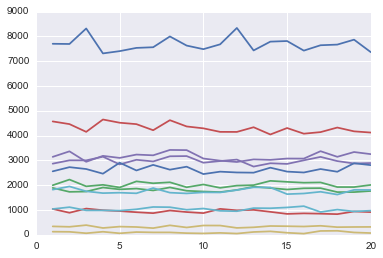

In [46]:
for chef, values in tqdm(chefs_and_vects.items()):
    inertias = {}
    for k in range(1,21):
        km = KMeans(n_clusters=k, init = 'k-means++', max_iter = 100, n_init = 1)
        km.fit(values[2])
        i = km.inertia_
        inertias[i] = k
    min_i = min(inertias.keys())
    #print chef
    #print 'minimum inertia:', min_i, ' when k =', inertias[min_i] 
    plt.plot(range(1,21), inertias.keys())

As we can infer from the inertia graph above, clustering based on titles is not a good idea.

#3. Clustering by titles *and* categories?

In [48]:
both_df = categories_df.drop('Cluster1', axis=1).drop('Cluster2', axis=1).drop('Course', axis=1)

In [49]:
both_df.head(3)

,Categories,Chef,Recipe
0,"[Sugar, Dessert, Frosting]",Giada De Laurentiis,Vanilla Frosting
1,"[Salmon, Main Dish, Jewish Cooking]",Giada De Laurentiis,Salmon Baked in Foil
2,"[Chicken, Main Dish, Pasta Dishes]",Giada De Laurentiis,Italian Baked Chicken and Pastina


In [54]:
titles = [str(r) for _, r in both_df['Recipe'].iteritems()]
titles = [re.compile('[^a-zA-Z]').sub(' ', r) for r in titles]
titles = [' '.join([word for word in r.split() if word[0] != word[0].lower()]) 
          for r in titles]
categories = [' '.join(c) for _, c in both_df['Categories'].iteritems()]
docs = zip(categories, titles)
docs = [' '.join(d) for d in docs]

In [55]:
docs[:3]

[u'Sugar Dessert Frosting Vanilla Frosting',
 u'Salmon Main Dish Jewish Cooking Salmon Baked Foil',
 u'Chicken Main Dish Pasta Dishes Italian Baked Chicken Pastina']

In [56]:
b_cv = CountVectorizer(docs)
b_matrix = b_cv.fit_transform(docs).toarray()

minimum inertia: 58079.0067998  when k = 20


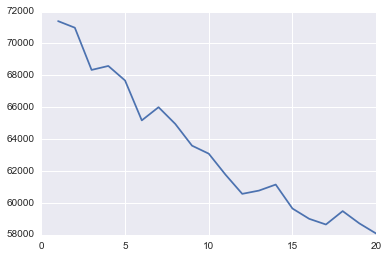

In [57]:
inertias = []
for k in tqdm(range(1,21)):
    km = KMeans(n_clusters=k, init = 'k-means++', max_iter = 100, n_init = 1)
    km.fit(b_matrix)
    i = km.inertia_
    inertias.append((k, i))    
sort_by_i = sorted(inertias, key=lambda inertia: inertia[1])
sort_by_k = sorted(inertias)
print 'minimum inertia:', sort_by_i[0][1], ' when k =', sort_by_i[0][0]
plt.plot(range(1,21), [inertia[1] for inertia in sort_by_k])

As we can infer from the inertia graph above, clustering based on categories *and* titles is not a good idea: titles introduce far more noise than they make up for.

#4. Updating `celebrity_recipes` collection

In [ ]:
for _, c in tqdm(categories_df.iterrows()):  
    celebrity_recipes.update_many({'chef': c['Chef'], 'title': c['Recipe']}, {
            '$set': {'course': c['Course']}})  

In [ ]:
cursor = recipe_links.find()
for recipe in tqdm(cursor):
    celebrity_recipes.update_many({'chef': recipe['chef'], 'title': recipe['title']}, {
            '$set': {'img_link': recipe['img_link'], 'page_link': recipe['page_link']}}) 